In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt

# For feature extraction
from sklearn.feature_extraction.text import CountVectorizer

# pre-processing of text
import string
import re 

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from time import time 

In [2]:
# Lets load and explore the dataset
our_data = pd.read_csv('./Data/Full-Economic-News-DFE-839861.csv',encoding='ISO-8859-1')

In [3]:
our_data.shape

(8000, 15)

In [4]:
our_data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [5]:
our_data.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'positivity', 'positivity:confidence', 'relevance',
       'relevance:confidence', 'articleid', 'date', 'headline',
       'positivity_gold', 'relevance_gold', 'text'],
      dtype='object')

In [6]:
our_data.relevance.value_counts()/our_data.shape[0]

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

In [7]:
our_data['relevance'].head(10)

0    yes
1     no
2     no
3     no
4    yes
5    yes
6     no
7     no
8     no
9    yes
Name: relevance, dtype: object

In [8]:
# Lets convert labels to numerics
our_data = our_data[our_data['relevance']!="not sure"]

In [9]:
our_data.shape

(7991, 15)

In [10]:
our_data['relevance'] = our_data['relevance'].map({
    'yes': 1,
    'no': 0
})

In [11]:
our_data.text[0]

'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

In [12]:
our_data = our_data[["text","relevance"]]

In [13]:
our_data.shape

(7991, 2)

### Text Pre-Processing

In [14]:
from nltk.corpus import stopwords
def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ")
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords.words('english')])
    return doc 

#### Modelling

In [15]:
import sklearn
from sklearn.model_selection import train_test_split

X = our_data.text 
y = our_data.relevance
X.shape,y.shape

((7991,), (7991,))

In [16]:
# Lets do the train test split now
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [17]:
# Preprocess and Vectorize train and test data
vect = CountVectorizer(preprocessor=clean)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

X_train_dtm.shape, X_test_dtm.shape

((5993, 49889), (1998, 49889))

In [18]:
# Using Multinomial Naive Bayes Model
nb = MultinomialNB()
nb.fit(X_train_dtm,y_train)

MultinomialNB()

In [19]:
y_pred_class = nb.predict(X_test_dtm)

Accuracy:  0.7707707707707707
ROC_AOC_Score:  0.7313141346092483


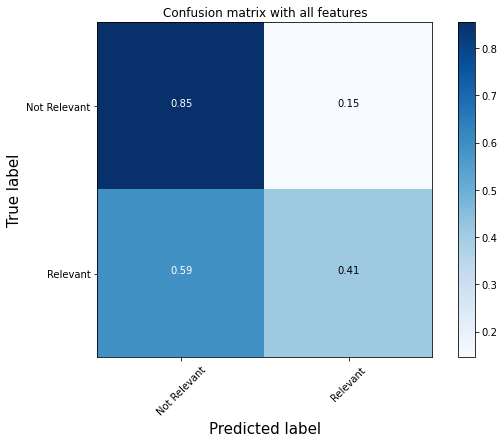

In [21]:
# Model Evaluation
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    
    
# Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

    
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
# Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))